<a href="https://colab.research.google.com/github/sooonsyk/Pocari/blob/main/img_preprocessing/whitebalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# whitebalance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.io import imread, imshow
from matplotlib.patches import Rectangle

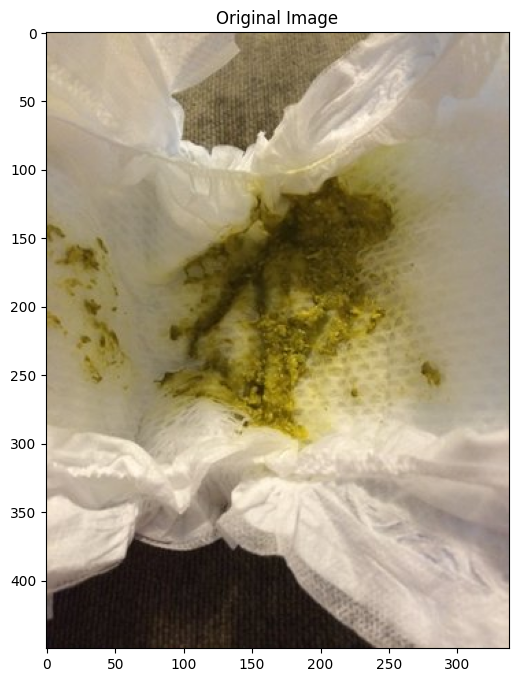

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

img_dir = '/content/drive/MyDrive/images_0601/green/green_5.png'
image = io.imread(img_dir)  #이미지 경로에서 np.array 형식으로 이미지 불러옴
plt.figure(figsize=(8,8))          #크기 설정
plt.title('Original Image')        #제목 설정
plt.imshow(image)
plt.show()							           #출력

In [ ]:
def calc_color_overcast(image):
    #각 color channel 별 색상 값 출력
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    # 색상별 평균, 표준편차, 최소값, 중앙값, 80%, 90%, 99%, 최대값 계산하여 데이터프레임 형식으로 출력
    channel_stats = pd.DataFrame(columns=['Mean', 'Std', 'Min', 'Median', 'P_80', 'P_90', 'P_99', 'Max'])

    for channel, name in zip([red_channel, green_channel, blue_channel], ['Red', 'Green', 'Blue']):
        mean = np.mean(channel)					    #평균 계산
        std = np.std(channel)					      #표준편차 계산
        minimum = np.min(channel)			  	  #최소값 계산
        median = np.median(channel)				  #중앙값 계산
        p_80 = np.percentile(channel, 80)		#80% 백분위수 계산
        p_90 = np.percentile(channel, 90)		#90% 백분위수 계산
        p_99 = np.percentile(channel, 99)   #99% 백분위수 계산
        maximum = np.max(channel)				    #최대값 계산

        channel_stats.loc[name] = [mean, std, minimum, median, p_80, p_90, p_99, maximum]

    return channel_stats

calc_color_overcast(image)

Mean        Std   Min  Median   P_80   P_90   P_99    Max
Red    157.796364  55.356248  15.0   166.0  203.0  220.0  245.0  255.0
Green  144.599684  54.565818   8.0   154.0  189.0  206.0  233.0  252.0
Blue   115.391072  59.916750   0.0   131.0  168.0  187.0  212.0  231.0

In [ ]:
def compare_imgs(left_img, right_img):              #비교를 위한 두 개의 이미지를 입력받아 나란히 출력

   fig, ax = plt.subplots(1, 2, figsize=(10, 10))   #화면을 2개로 분할한다
   ax[0].imshow(left_img)							              #왼쪽 이미지 출력
   ax[0].set_title('Original Image')
   ax[0].axis('off')								                #깔끔한 이미지를 위한 축 제거

   ax[1].imshow(right_img)							            #오른쪽 이미지 출력
   ax[1].set_title('Corrected Image')
   ax[1].axis('off')

   plt.show()

### 0. OpenCV 라이브러리 내장 auto white balance 함수 적용

In [ ]:
#!pip install opencv-python opencv-contrib-python

In [ ]:
import cv2

def simple_white_balance(image):
    wb = cv2.xphoto.createSimpleWB()
    return wb.balanceWhite(image)

def grayworld_white_balance(image):
    wb = cv2.xphoto.createGrayworldWB()
    return wb.balanceWhite(image)

def learning_based_white_balance(image):
    wb = cv2.xphoto.createLearningBasedWB()
    return wb.balanceWhite(image)

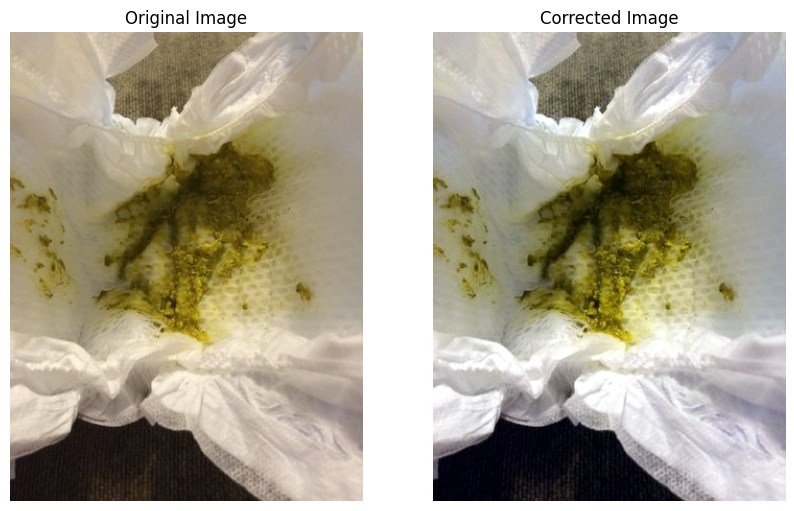

In [ ]:
cv_simple_img = simple_white_balance(image)
compare_imgs(image, cv_simple_img)

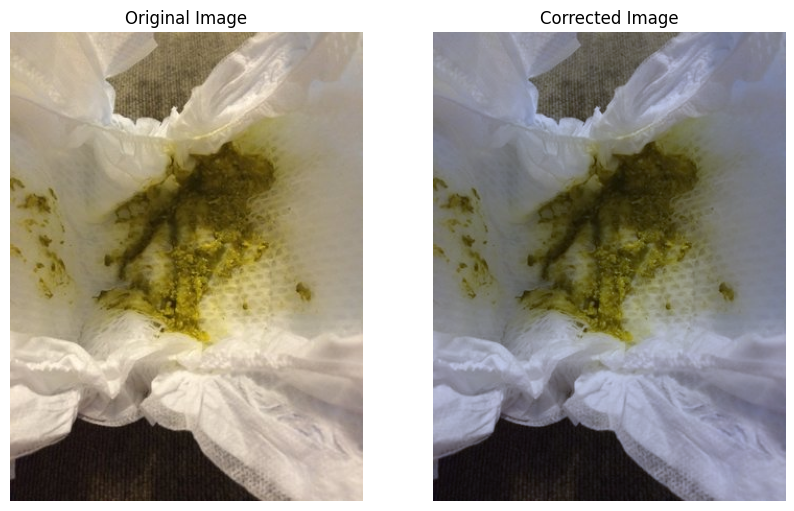

In [ ]:
cv_gw_img = grayworld_white_balance(image)
compare_imgs(image, cv_gw_img)

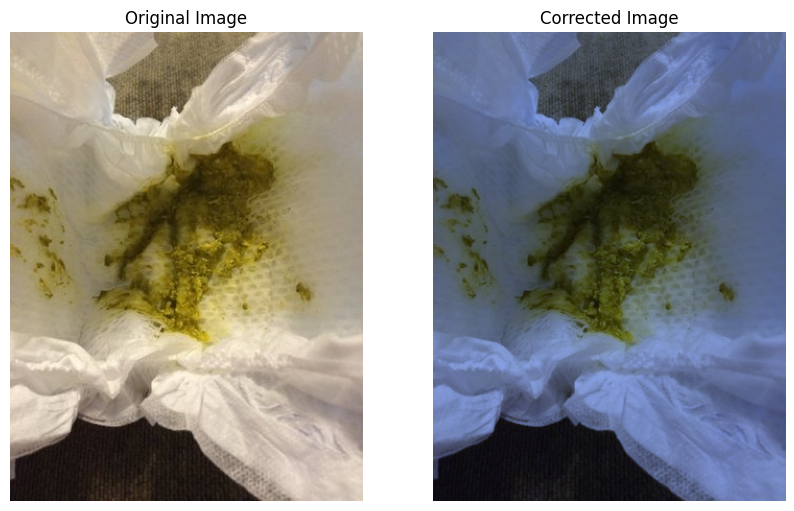

In [ ]:
cv_lb_img = learning_based_white_balance(image)
compare_imgs(image, cv_lb_img)

### 1. white patch algorithm

In [ ]:
def white_patch(image, percentile=100):

    """
    Parameters
    ----------
    image : 입력으로 받는 이미지는 RGB 채널을 각각 가지는 (height, width, channels) 3차원 numpy 배열
    percentile : 채널 값의 보정값으로 사용하고자 하는 값을 지정하기 위한 비율, 기본값은 100으로 최대값을 사용
    """

    white_patch_image = img_as_ubyte((
                                      image * 1.0          #이미지 배열을 부동 소수점 형식으로 변환하여 나눗셈 연산이 제대로 수행되도록 함
        							                / np.percentile      #지정된 백분위 수 계산
                                      	  (image, 	            #입력 이미지
                                     	    percentile,           #입력 퍼센티지
                                     	    axis=(0, 1)           #높이, 너비 축을 따라 계산
                                          )                #이미지가 반환된 보정값을 사용해 정규화 됨
                                      ).clip(0, 1)         #0,1 사이의 범위로 맞춰줌
                                     )
    return white_patch_image

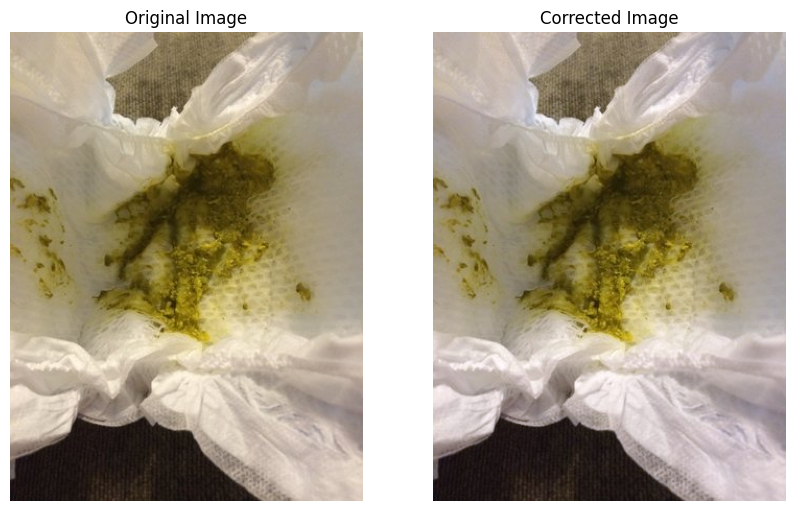

In [ ]:
white_patch_image = white_patch(image, 100)
compare_imgs(image, white_patch_image)

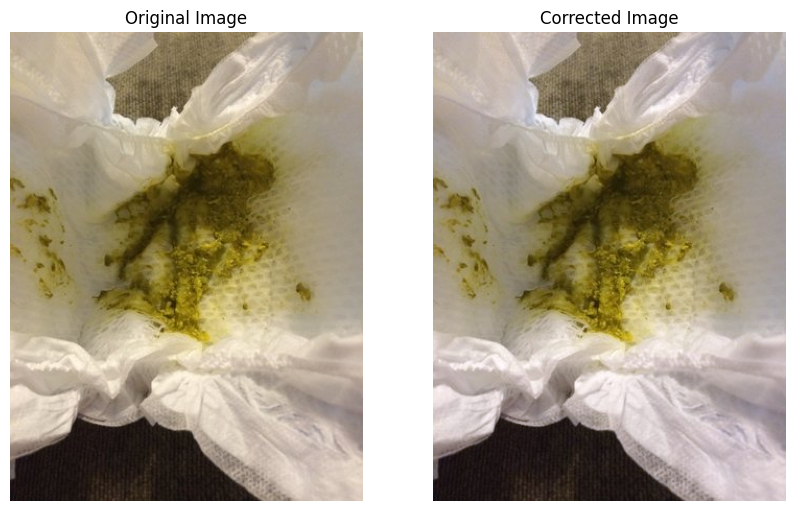

In [ ]:
#percentile 값 조정
white_patch_img = white_patch(image, 85)
compare_imgs(image, white_patch_image)

### 2. Gray World Algorithm

In [ ]:
def gray_world(image):

    """
    Parameters
    ----------
    image : 입력으로 받는 이미지는 RGB 채널을 각각 가지는 (height, width, channels) 3차원 numpy 배열
    """

    gray_world_image = ((image *
                        	(image.mean() 				          #전체 이미지의 평균
                           / image.mean(axis=(0, 1)))  	  #각 채널별 평균
                        )  									          #각 채널의 평균 값이 동일해짐
                        .clip(0, 255).astype(int))		#이미지 형식으로 변환

    return gray_world_image

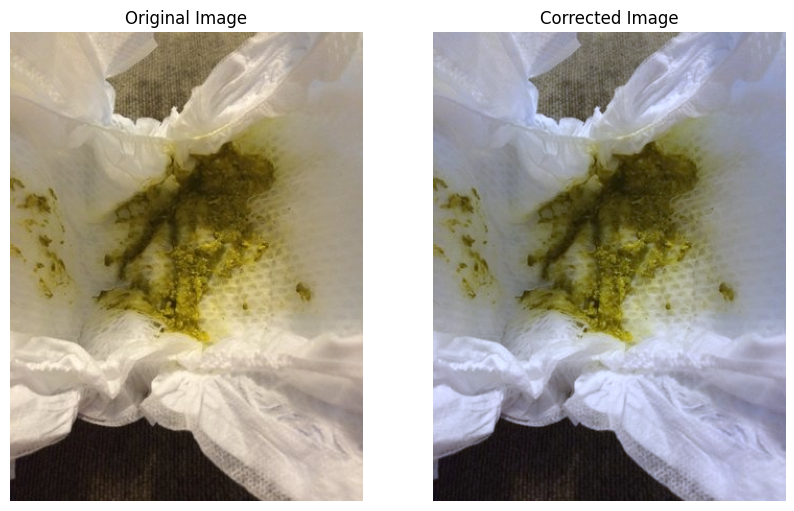

In [ ]:
gray_world_image = gray_world(image)
compare_imgs(image, gray_world_image)

### 3. Ground Truth Algorithm

In [ ]:
def ground_truth(image, img_patch, mode='mean'):

    """
    Parameters
    ----------
    image : 입력으로 받는 이미지는 RGB 채널을 각각 가지는 (height, width, channels) 3차원 numpy 배열
    img_patch : 기준으로 삼을 레퍼런스
    mode : optional, mean 혹은 max로 계산 방법 설정
    """

    # 평균을 사용하는 경우 - gray world 에서의 보정 방식과 동일
    if mode == 'mean':
        ground_truth_image = ((image * (img_patch.mean() / image.mean(axis=(0, 1)))).clip(0, 255).astype(int))

    # 최대값을 사용하는 경우 - white patch 에서의 보정 방식과 동일
    if mode == 'max':
        ground_truth_image = ((image * 1.0 / img_patch.max(axis=(0, 1))).clip(0, 1))

    return ground_truth_image

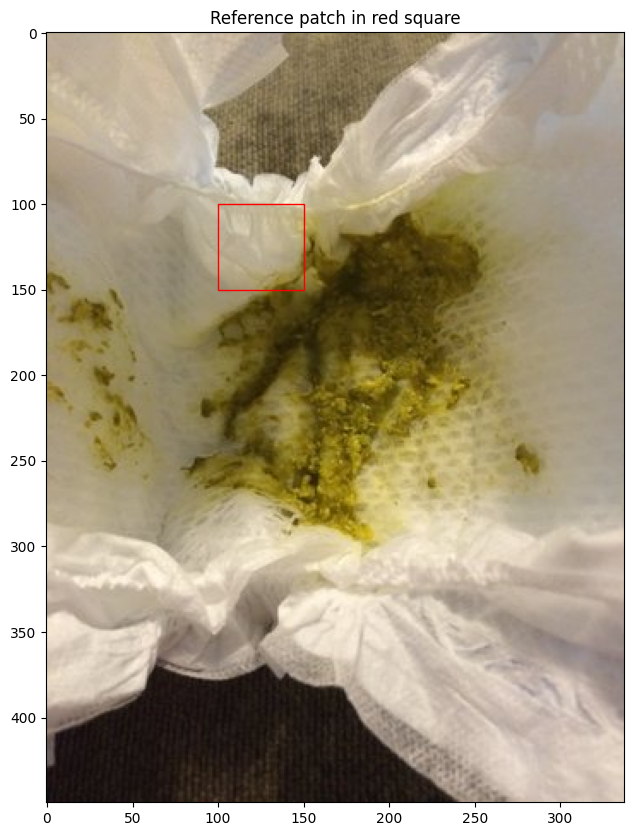

In [ ]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Reference patch in red square')
ax.imshow(image)
ax.add_patch(Rectangle((100,100), 50, 50, edgecolor='r', facecolor='none'));

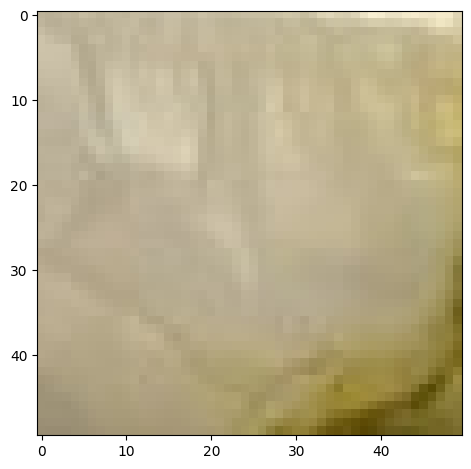

In [ ]:
img_patch = image[100:150,100:150]
imshow(img_patch)

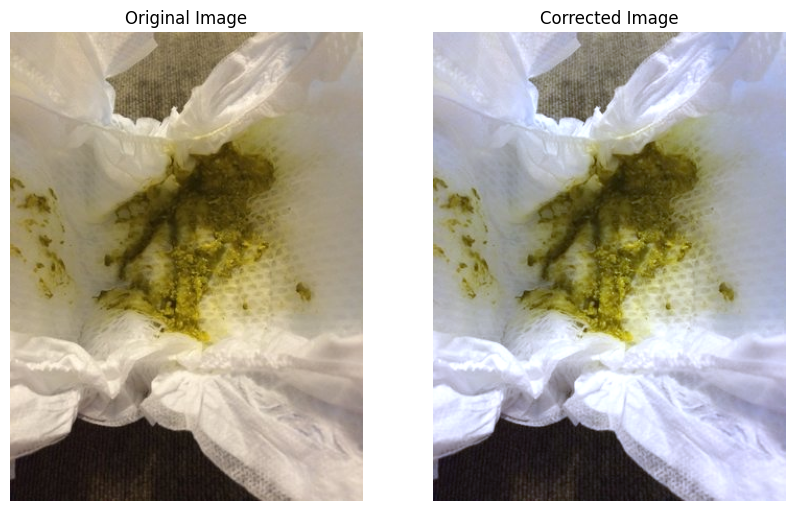

In [ ]:
#평균 사용
ground_truth_image = ground_truth(image, img_patch, mode='mean')
compare_imgs(image, ground_truth_image)

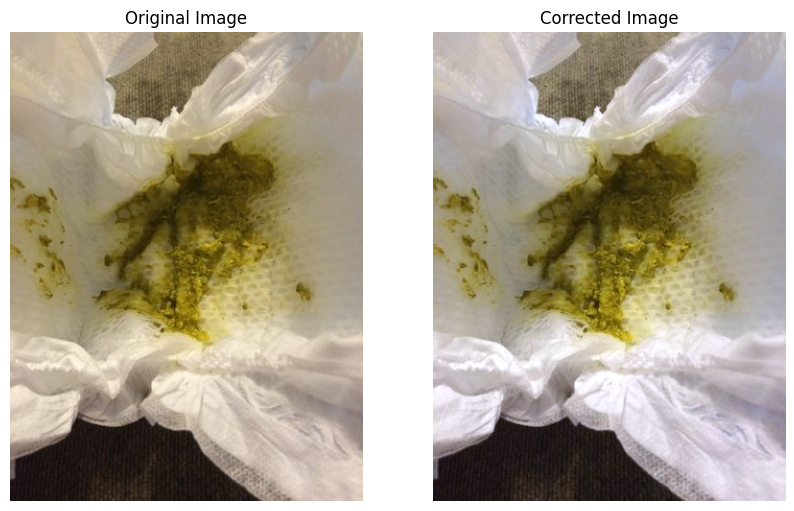

In [ ]:
#최대값 사용
ground_truth_image = ground_truth(image, img_patch, mode='max')
compare_imgs(image, ground_truth_image)

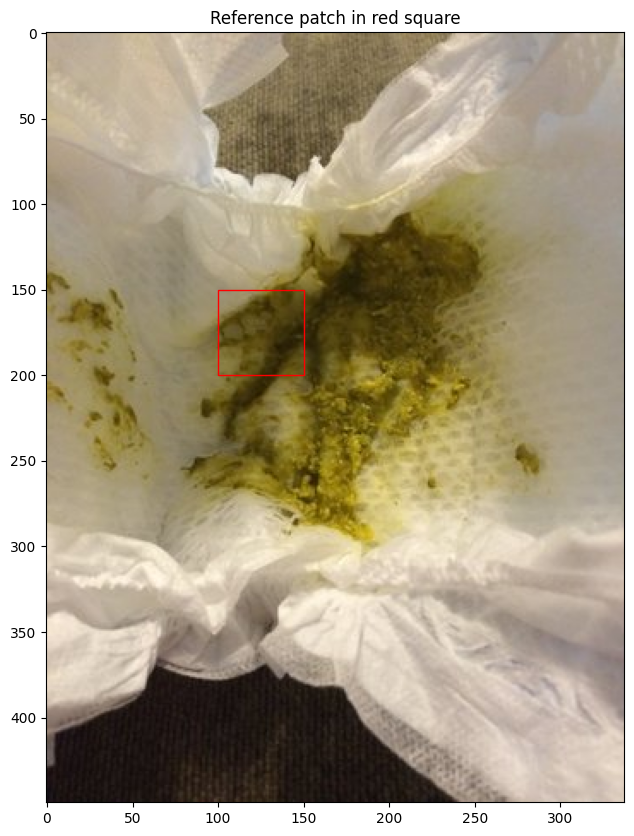

In [ ]:
from matplotlib.patches import Rectangle   #이미지 위에 사각형을 그릴 수 있게 해줌

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Reference patch in red square')
ax.imshow(image)
ax.add_patch(Rectangle((100, 150), 50, 50, edgecolor='r', facecolor='none'))		#사각형의 왼쪽 위 모서리 좌표, 사각형의 너비, 높이, 테두리 색상(빨간색), 사각형 내부 (투명하게) 설정

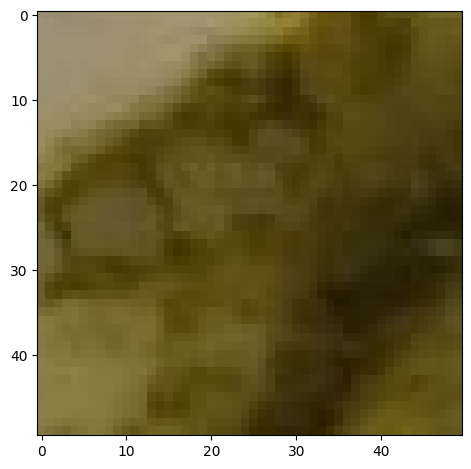

In [ ]:
#레퍼런스 출력
img_patch = image[150:200, 100:150]    #행, 열을 그대로 사용하므로 위의 Rectangle과 달리 y,x 순서로 입력해주어야 함을 조심
imshow(img_patch)

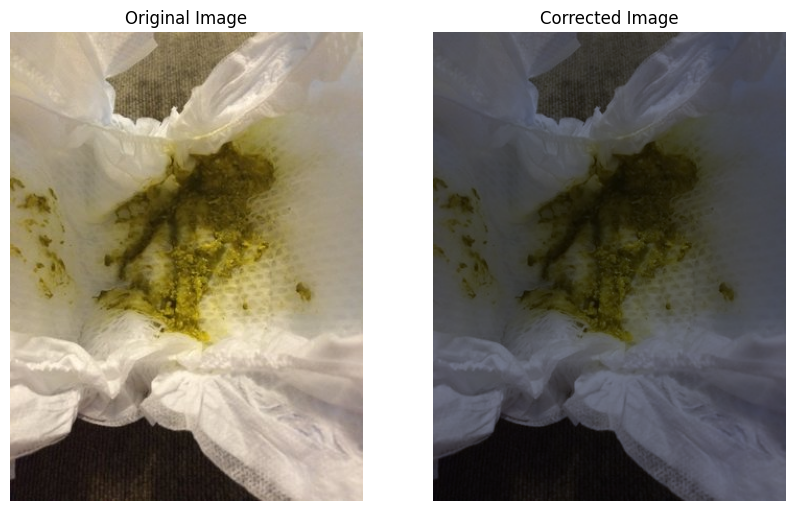

In [ ]:
#평균 사용
ground_truth_image = ground_truth(image, img_patch, mode='mean')
compare_imgs(image, ground_truth_image)

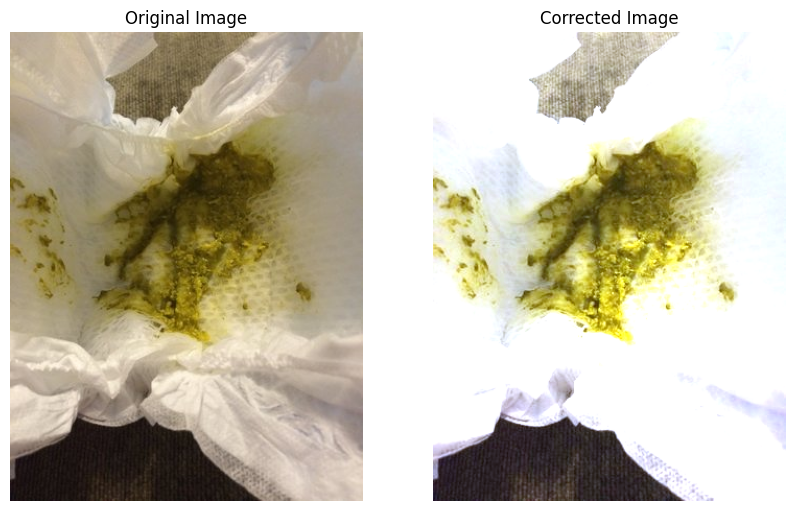

In [ ]:
#최대값 사용
ground_truth_image = ground_truth(image, img_patch, mode='max')
compare_imgs(image, ground_truth_image)

In [ ]:
def white_patch(image, percentile=100):

    """
    Parameters
    ----------
    image : 입력으로 받는 이미지는 RGB 채널을 각각 가지는 (height, width, channels) 3차원 numpy 배열
    percentile : 채널 값의 보정값으로 사용하고자 하는 값을 지정하기 위한 비율, 기본값은 100으로 최대값을 사용
    """

    white_patch_image = img_as_ubyte((image * 1.0 / np.percentile(image,percentile, axis=(0, 1))).clip(0, 1))

    return white_patch_image

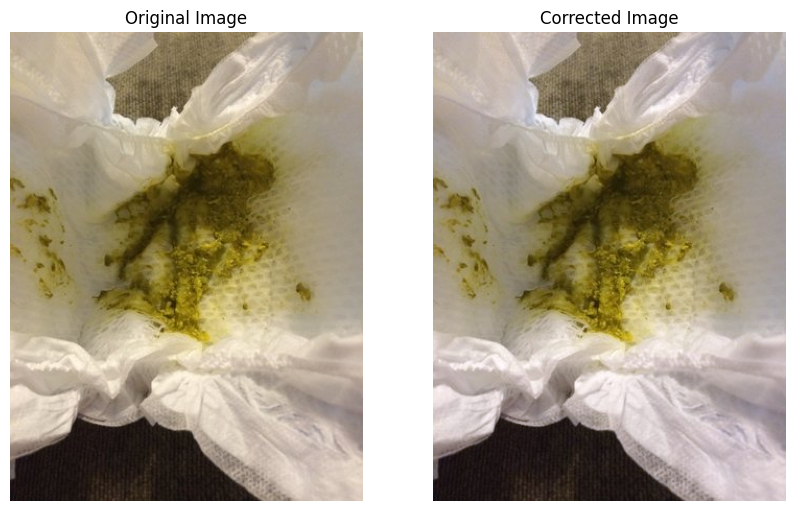

In [ ]:
white_patch_image = white_patch(image, 100)
compare_imgs(image, white_patch_image)